In [65]:
import pandas as pd
import numpy as np
import math 

from pandas.plotting import scatter_matrix, parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns





import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import time


pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings('ignore') 

#%matplotlib inline

In [45]:
df = pd.read_csv('Fundraising.csv')
df = df.drop(['Row Id.', 'TARGET_D'], axis = 1)

In [46]:
df = df.drop('Row Id', axis = 1)

### EDA

In [15]:
df.head(10)

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,TARGET_B
0,0,1,0,0,1,1,5,1,9,1399,...,703,1,74,102.00000,6.00000,5.00000,29,3,4.85714,1
1,1,0,0,0,1,1,1,0,7,698,...,463,4,46,94.00000,12.00000,12.00000,34,6,9.40000,1
2,0,0,0,1,0,2,5,1,8,828,...,376,13,32,30.00000,10.00000,5.00000,29,7,4.28571,1
3,0,0,0,1,1,1,3,0,4,1471,...,546,4,94,177.00000,10.00000,8.00000,30,3,7.08000,0
4,0,1,0,0,1,1,4,0,8,547,...,432,7,20,23.00000,11.00000,11.00000,30,6,7.66667,0
5,0,1,0,0,1,1,4,1,8,482,...,275,28,38,73.00000,10.00000,10.00000,31,3,7.30000,1
6,0,0,0,1,1,1,4,1,8,857,...,498,5,47,139.00000,20.00000,20.00000,37,3,10.69231,1
7,1,0,0,0,1,1,1,0,7,1355,...,497,9,77,249.00000,15.00000,7.00000,35,3,9.57692,1
8,0,0,1,0,1,1,4,0,5,505,...,388,16,51,63.00000,15.00000,10.00000,37,8,9.00000,1
9,1,0,0,0,1,1,4,1,8,1438,...,533,8,21,26.00000,16.00000,16.00000,30,6,13.00000,0


In [10]:
df['TARGET_B'].value_counts()

1    1560
0    1560
Name: TARGET_B, dtype: int64

In [11]:
df.isna().any()

Row Id             False
zipconvert_2       False
zipconvert_3       False
zipconvert_4       False
zipconvert_5       False
homeowner dummy    False
NUMCHLD            False
INCOME             False
gender dummy       False
WEALTH             False
HV                 False
Icmed              False
Icavg              False
IC15               False
NUMPROM            False
RAMNTALL           False
MAXRAMNT           False
LASTGIFT           False
totalmonths        False
TIMELAG            False
AVGGIFT            False
TARGET_B           False
dtype: bool

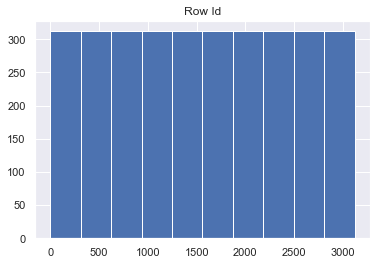

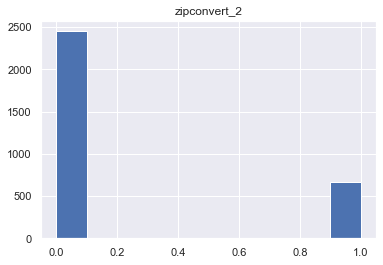

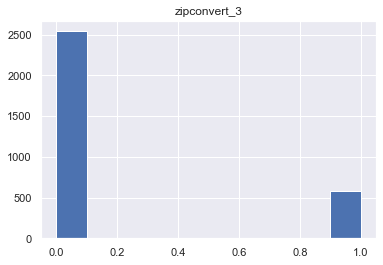

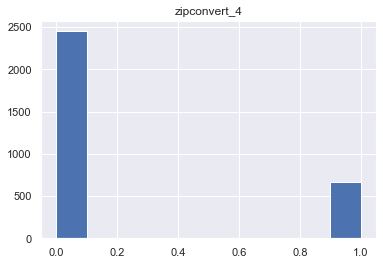

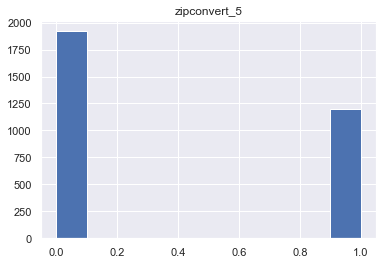

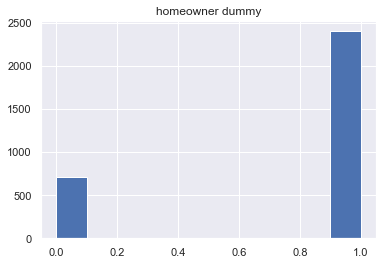

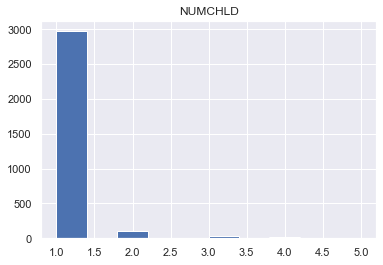

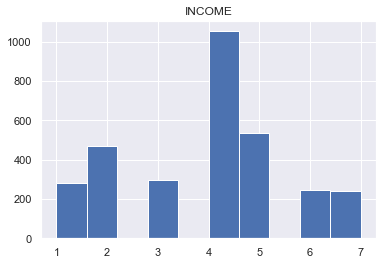

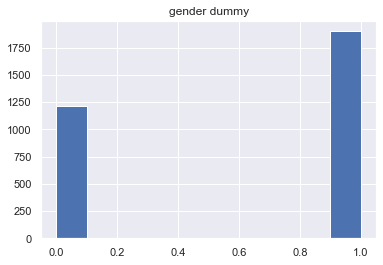

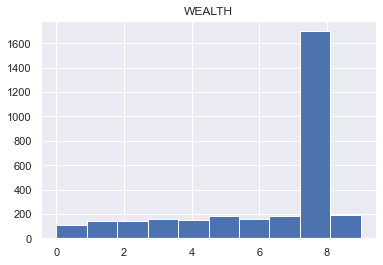

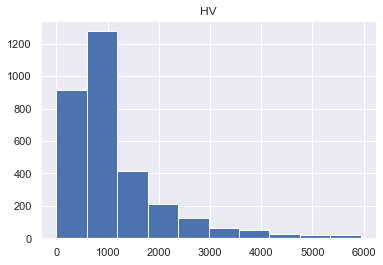

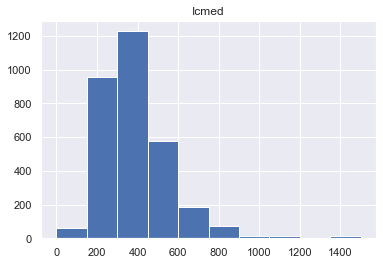

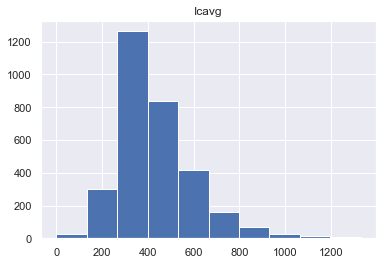

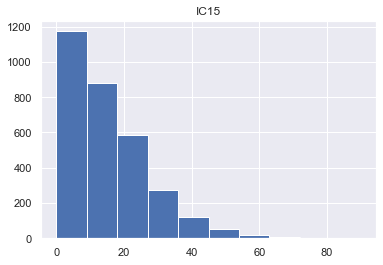

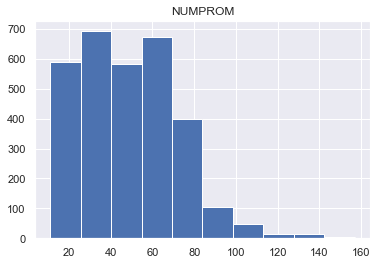

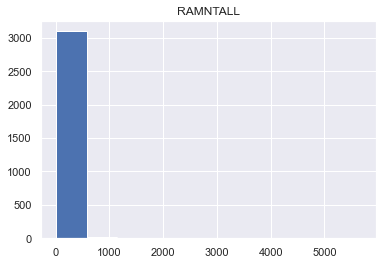

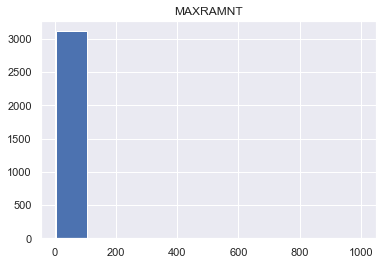

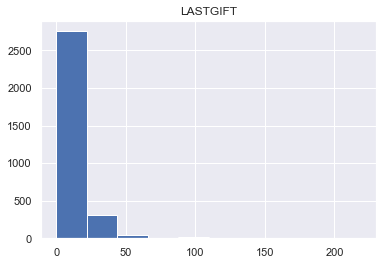

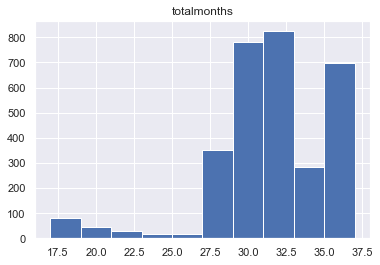

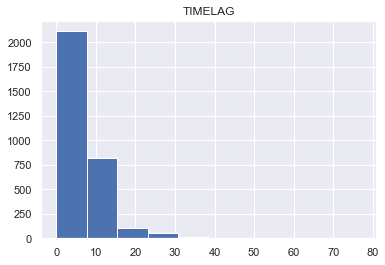

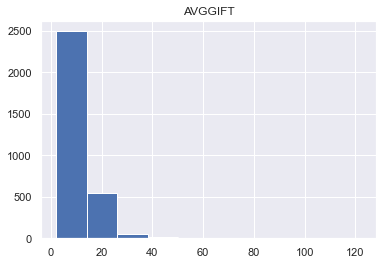

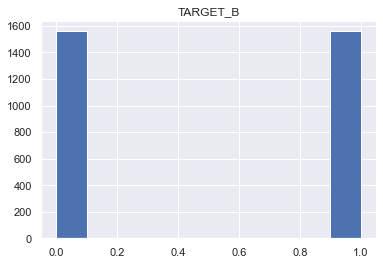

In [12]:
for variable in df.columns:
    df[variable].hist()
    plt.title(variable)
    plt.show()

<AxesSubplot:>

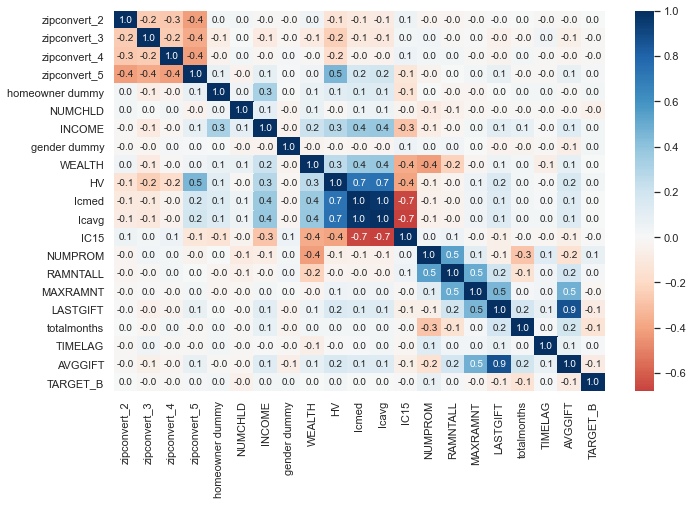

In [17]:
corr = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr, annot = True, fmt = '.1f', cmap = 'RdBu', center = 0, ax = ax)

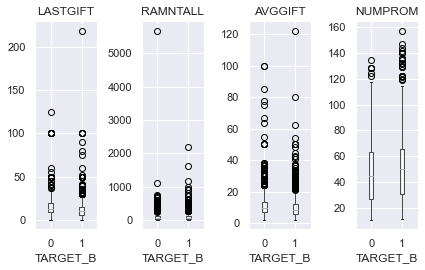

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 4)
df.boxplot(column = 'LASTGIFT', by = 'TARGET_B', ax = axes[0])
df.boxplot(column = 'RAMNTALL', by = 'TARGET_B', ax = axes[1])
df.boxplot(column = 'AVGGIFT', by = 'TARGET_B', ax = axes[2])
df.boxplot(column = 'NUMPROM', by = 'TARGET_B', ax = axes[3])


for ax in axes:
    ax.set_xlabel('TARGET_B')
    
plt.suptitle('')
plt.tight_layout()

<Figure size 792x504 with 0 Axes>

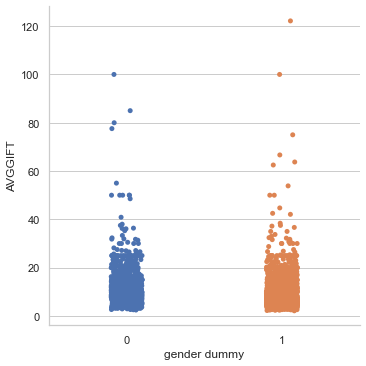

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(11,7))
sns.catplot(x = 'gender dummy', y = 'AVGGIFT', order = [0, 1], data = df)

<Figure size 792x504 with 0 Axes>

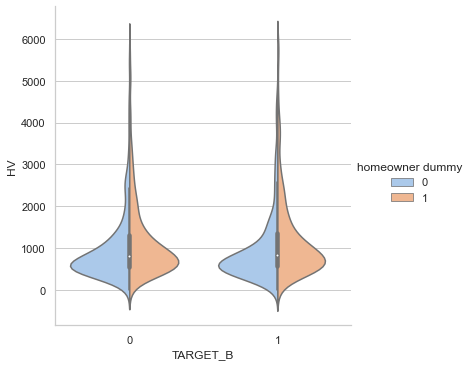

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(11,7))
sns.catplot(x="TARGET_B", y="HV", hue="homeowner dummy", kind="violin", split=True, palette="pastel", data=df)

<Figure size 864x504 with 0 Axes>

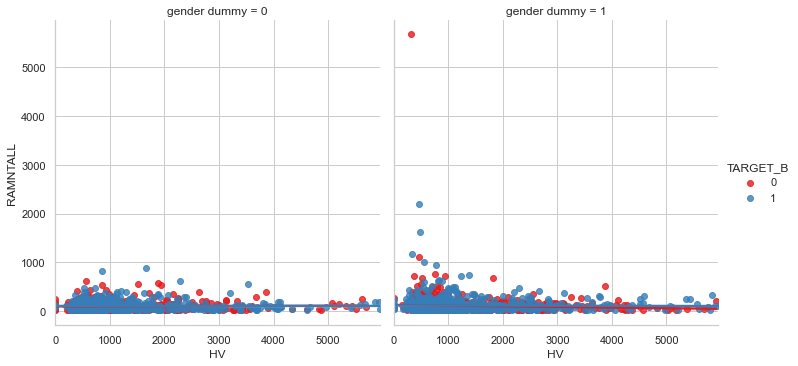

In [40]:
plt.figure(figsize=(12,7))
sns.lmplot(x = 'HV', y = 'RAMNTALL', col = 'gender dummy', hue = 'TARGET_B', palette='Set1', data = df)

### Split Data & Train Model

In [51]:
X = df.drop(['TARGET_B'], axis = 1)
y = df['TARGET_B']

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 12345)

In [53]:
parameters = {
        'max_depth': range(2, 6),
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'colsample_bynode': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'gamma': [0, 5, 10, 15, 20],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'lambda': [0.1, 0.25, 0.5, 0.75, 1]
}

start = time.time() 

clf = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = "logloss"), 
                         parameters, n_jobs=4, scoring = "roc_auc", n_iter = 300,
                         random_state = 123)

clf.fit(X_train, y_train)

end = time.time()

# print the number of seconds it takes to run the hyperparameter search
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  328.9789788722992


In [ ]:
#optimal hyperparameters
clf.best_params_

In [54]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(X_valid)

### Feature Importance

In [58]:
imp = pd.DataFrame()


imp["var"] = X_train.columns


imp["imp"] = clf.best_estimator_.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)

# print out the data frame
imp

,var,imp
0,totalmonths,0.15601
1,NUMPROM,0.14916
2,AVGGIFT,0.13694
3,Icmed,0.13635
4,MAXRAMNT,0.12529
5,HV,0.09699
6,RAMNTALL,0.08997
7,gender dummy,0.06025
8,LASTGIFT,0.04904
9,homeowner dummy,0.00000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance score', ylabel='Features'>

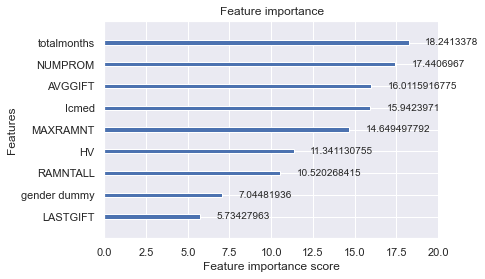

In [59]:
# non-normalized feature importance
xgb.plot_importance(clf.best_estimator_, importance_type = "gain", xlabel = "Feature importance score")

### Model Performance 

In [56]:
print("Training recall: ", metrics.recall_score(y_train, train_pred))
print("Validation recall: ", metrics.recall_score(y_valid, val_pred))

print("\n")

print("Training precision: ", metrics.precision_score(y_train, train_pred))
print("Validation precision: ", metrics.precision_score(y_valid, val_pred))

print("\n")

print("Training accuracy: ", metrics.accuracy_score(y_train, train_pred))
print("Validation accuracy: ", metrics.accuracy_score(y_valid, val_pred))

print("\n")

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_val_prob[:,1], pos_label = 1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training recall:  0.5714285714285714
Validation recall:  0.5314533622559653


Training precision:  0.5847299813780261
Validation precision:  0.5456570155902004


Training accuracy:  0.5801282051282052
Validation accuracy:  0.5512820512820513


Training AUC:  0.6203725213117915
Validation AUC:  0.5680146135403584


Confusion matrix, without normalization
[[271 204]
 [216 245]]
Normalized confusion matrix
[[0.57052632 0.42947368]
 [0.46854664 0.53145336]]


<Figure size 936x576 with 0 Axes>

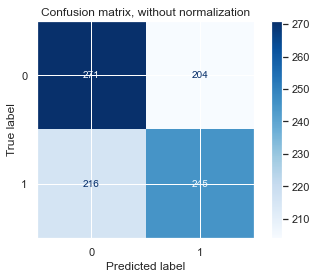

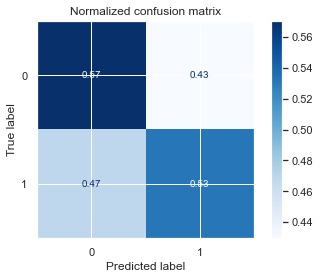

In [73]:
plt.figure(figsize=(13,8))

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_valid, y_valid, cmap=plt.cm.Blues,normalize=normalize)
                                 
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)